In [1]:
import sys
from pathlib import Path

def get_project_root():
    for path in (Path.cwd(), *Path.cwd().parents):
        if (path / 'src').exists():
            return path
    raise ModuleNotFoundError("Could not find 'src' directory from current working directory.")

project_root = get_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.plot_data_utils import PlotDataUtils
from src.classical_MILP_solver_with_weather_data import ClassicalMILPSolverWithWeatherData


In [2]:
# Initialise utilities for the input CSV data
data_utils = PlotDataUtils(Path('../data/input_data.csv'))

# Then load the data
df = data_utils.load_data()

Now we complicate the problem. Up to this point, we were assumming that the power generation of the wind farm only affects the final revenue, but not battery schedule. This was directly inherited from the "no-netting" condition stated in the challenge. Now, in a more realistic situation, we do not have complete freedom to speculate over the market prices to maximize our profits. We must comply with the grid demand too, being penalized otherwise (eg. choosing to buy because of low market price, when our wind generation is below market demand and we should instead dump energy into the grid)

Following D. Pozo, _Linear Battery Models for Power Systems Analysis_ (2022), we do so by solving a set-point tracking (SPT) problem. This is a class of problem where we aim to follow (track) an imposed target quantity by optimizing over the decision variables. This perfectly fits our problem, where we want to track the net battery demand set by the difference between deterministic predicted grid demand and our stochastic wind generation. The BESS defines the same constraints that were considered previously, and the QAOA input is also the same. However, instead of maximizing the revenue, the SPT now minimizes the function

$$\sum_{t=1}^{24} |f_t| \ \quad;\quad f_t = d_t - c_t - p^\text{sig}_t$$

for each scenario, where $f_t$ is the difference between the actual net battery injection $d_t-c_t$ and the target net battery injection (the net demand) $p^\text{sig}_t=D_t-W_t$.

We adopt an isoelastic price–demand model because it captures constant relative price responsiveness, is empirically supported in electricity markets, admits a clear welfare-theoretic foundation, and remains robust under the large price fluctuations induced by renewable generation.Following this model, we can get the market demand from the market price, via

$$D_t = A p_t^{-\epsilon}$$

Empirically it has been found that for Spain's energy market, $\epsilon=0.25$. Now the price-energy $A$ scaling is a bit more subtle. We fix it by enforcing that the total demand over the 24 hour period equals the total wind generation over this period averaged over all scenarios

$$A = \frac{\mathbb{E}_s \sum_t W_{t,s}}{\sum_t p_t^{-\epsilon}}$$



## Stochastic signal-tracking MILP (13 independent scenarios)

### High-level idea

We keep the same battery physics and “continuous operation” logic as in the pure arbitrage model, but we additionally define a **scenario-dependent baseline signal** $p_{\text{sig},t,s}$ and penalize deviations between the battery’s net grid injection and this signal.

Concretely, for each wind scenario $s\in\{1,\dots,13\}$ we build and solve an independent MILP that chooses a battery schedule $(c_t,d_t,E_t)$ so that the **net battery output** $(d_t-c_t)$ tracks a target profile $p_{\text{sig},t,s}$, while respecting SOC, power, cycling, and block-count constraints.

---

### Data and signal definition

- Hours: $t\in\{1,\dots,24\}$
- Wind realizations per scenario: $W_{t,s}$
- Deterministic demand profile (calculated from mrket price): $D_t$

We define the **scenario-dependent signal** as the residual demand after wind:
$ p_{\text{sig},t,s} = D_t - W_{t,s} $

In code (arrays indexed $0..23$, hours are $1..24$):
- `wind_gen = winds[:, s]`
- `demand = (np.sum(np.mean(winds,axis=1)) / np.sum(price**(-0.25))) * price ** (- 0.25)`
- `p_sig[t] = demand[t-1] - wind_gen[t-1]`

---

### Decision variables (per scenario)

Continuous variables:
- $c_t \ge 0$ : charging energy bought from grid (MWh) at hour $t$
- $d_t \ge 0$ : discharging energy sold to grid (MWh) at hour $t$
- $E_t \in [0,E^{\max}]$ : SOC at end of hour $t$ (MWh)

Binary 3-state operation:
- $y^{\text{ch}}_t, y^{\text{dis}}_t, y^{\text{id}}_t \in \{0,1\}$

Binary start (block) indicators:
- $u^{\text{ch}}_t, u^{\text{dis}}_t \in \{0,1\}$  
  where $u^{\text{ch}}_t=1$ means “a charging block starts at $t$”, similarly for discharging.

Tracking linearization variables (L1 penalty):
- $\text{dev}_t \in \mathbb{R}$ and $\text{abs\_dev}_t \ge 0$

---

### Constraints (per scenario)

#### 1) SOC dynamics and bounds
$ \begin{aligned}
E_t &= E_{t-1} + \eta_{\text{ch}} c_t - \frac{1}{\eta_{\text{dis}}} d_t \quad \forall t \\
0 &\le E_t \le E^{\max} \quad \forall t \\
E_0 &= 0,\quad E_{24}=0
\end{aligned} $

#### 2) 3-state operation and power limits
$ \begin{aligned}
y^{\text{ch}}_t + y^{\text{dis}}_t + y^{\text{id}}_t &= 1 \quad \forall t \\
0 \le c_t &\le P^{\max}_{\text{ch}}\, y^{\text{ch}}_t \quad \forall t \\
0 \le d_t &\le P^{\max}_{\text{dis}}\, y^{\text{dis}}_t \quad \forall t
\end{aligned} $

(Optionally tighten with $\varepsilon>0$: $c_t \ge \varepsilon y^{\text{ch}}_t$, $d_t \ge \varepsilon y^{\text{dis}}_t$.)

#### 3) “Continuous operation”: forbid immediate charge↔discharge reversals
Must pass through idle when switching between opposite modes:
$ \begin{aligned}
y^{\text{ch}}_{t} + y^{\text{dis}}_{t+1} &\le 1 \quad \forall t=1,\dots,23 \\
y^{\text{dis}}_{t} + y^{\text{ch}}_{t+1} &\le 1 \quad \forall t=1,\dots,23
\end{aligned} $

#### 4) Start/block counting (tight linear constraints)
Initialize at $t=1$:
$ u^{\text{ch}}_{1} = y^{\text{ch}}_{1},\quad u^{\text{dis}}_{1} = y^{\text{dis}}_{1} $

For $t=2,\dots,24$ enforce $u_t = 1$ iff mode turns on after being off:
$ \begin{aligned}
u^{\text{ch}}_t &\ge y^{\text{ch}}_t - y^{\text{ch}}_{t-1},\quad
u^{\text{ch}}_t \le y^{\text{ch}}_t,\quad
u^{\text{ch}}_t \le 1 - y^{\text{ch}}_{t-1} \\
u^{\text{dis}}_t &\ge y^{\text{dis}}_t - y^{\text{dis}}_{t-1},\quad
u^{\text{dis}}_t \le y^{\text{dis}}_t,\quad
u^{\text{dis}}_t \le 1 - y^{\text{dis}}_{t-1}
\end{aligned} $

#### 5) Limit number of charge/discharge blocks
$ \sum_{t=1}^{24} u^{\text{ch}}_t \le 2,\quad \sum_{t=1}^{24} u^{\text{dis}}_t \le 2 $

#### 6) Cycle budget proxy (EFC)
$ \sum_{t=1}^{24} d_t \le N^{\text{cyc}} E^{\max} = 32 $

#### 7) Tracking deviation definition (L1 penalty)
Define deviation between realized net injection and the signal:
$ \text{dev}_t = (d_t - c_t) - p_{\text{sig},t,s} $

Linearize absolute value:
$ \text{abs\_dev}_t \ge \text{dev}_t,\quad \text{abs\_dev}_t \ge -\text{dev}_t,\quad \text{abs\_dev}_t \ge 0 $

---

### Objective (per scenario)

There are two common variants:

**A) Pure tracking + switching regularization** (this matches your current code line)
$ \min \ \gamma \sum_{t=1}^{24} \text{abs\_dev}_t \ +\ \lambda \sum_{t=1}^{24}\left(u^{\text{ch}}_t+u^{\text{dis}}_t\right) $

In PuLP (maximize form):
- `model += - track_penalty - start_penalty`

**B) Arbitrage + tracking + switching** (if you also want price incentives)
Let the arbitrage revenue be:
$ \text{Rev}^{\text{batt}} = \sum_{t=1}^{24} p_t (d_t - c_t) $

Then:
$ \max \ \text{Rev}^{\text{batt}} \ -\ \gamma \sum_{t=1}^{24} \text{abs\_dev}_t \ -\ \lambda \sum_{t=1}^{24}\left(u^{\text{ch}}_t+u^{\text{dis}}_t\right) $

In PuLP:
- `model += battery_revenue - track_penalty - start_penalty (+ wind_revenue_s if you want reporting)`

Note: under “no netting”, the **wind revenue term** does not depend on battery decisions, but the **signal** $p_{\text{sig},t,s}$ *does* depend on wind, so the optimal battery schedule becomes scenario-dependent through the tracking penalty.

---

### Algorithmic structure (what the code is doing)

1. Read all 13 wind scenarios from the dataset and compute descriptive wind-revenue stats (optional reporting).
2. For each scenario $s=1,\dots,13$:
   - Extract $W_{t,s}$ as `wind_gen`
   - Build $p_{\text{sig},t,s}=D_t-W_{t,s}$
   - Build a MILP with:
     - SOC recursion and bounds
     - 3-state mode + power limits
     - no immediate charge↔discharge reversal
     - start variables and block limits
     - cycle proxy limit
     - L1 tracking penalty via `dev`/`abs_dev`
   - Solve with CBC (`pulp.PULP_CBC_CMD`)
   - Export a per-hour schedule DataFrame with charge/discharge/SOC, modes, starts, and tracking diagnostics.

The result is `schedules`: a list of 13 DataFrames (one per scenario), each containing:
- `p_sig`, `charge_MWh`, `discharge_MWh`, `soc_MWh`
- `mode_charge`, `mode_discharge`, `mode_idle`
- `start_charge_block`, `start_discharge_block`
- `dev`, `abs_dev`


Summary: {'expected_wind_revenue': 17645.47633746154, 'wind_revenue_min': 5515.785612000001, 'wind_revenue_max': 27116.029714, 'mean_battery_revenue': np.float64(-820.4971553910946), 'mean_tracking_penalty': np.float64(91.77303644261539), 'mean_start_penalty': np.float64(0.0)}


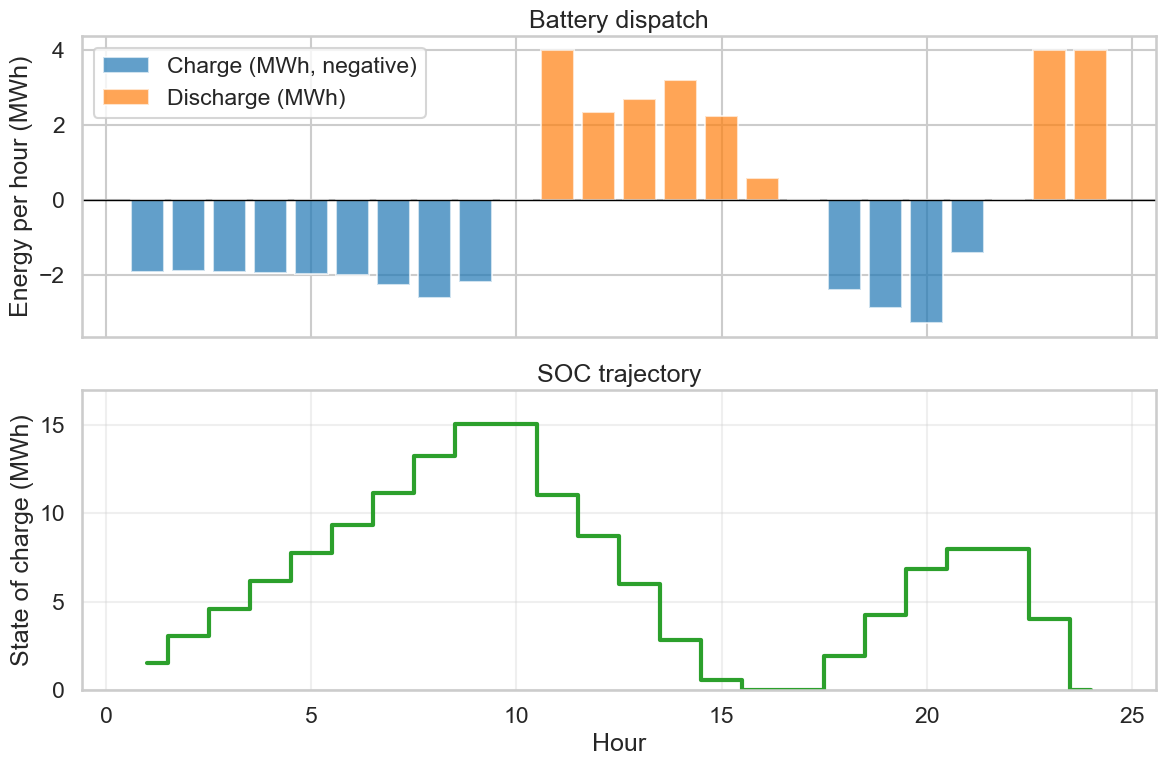

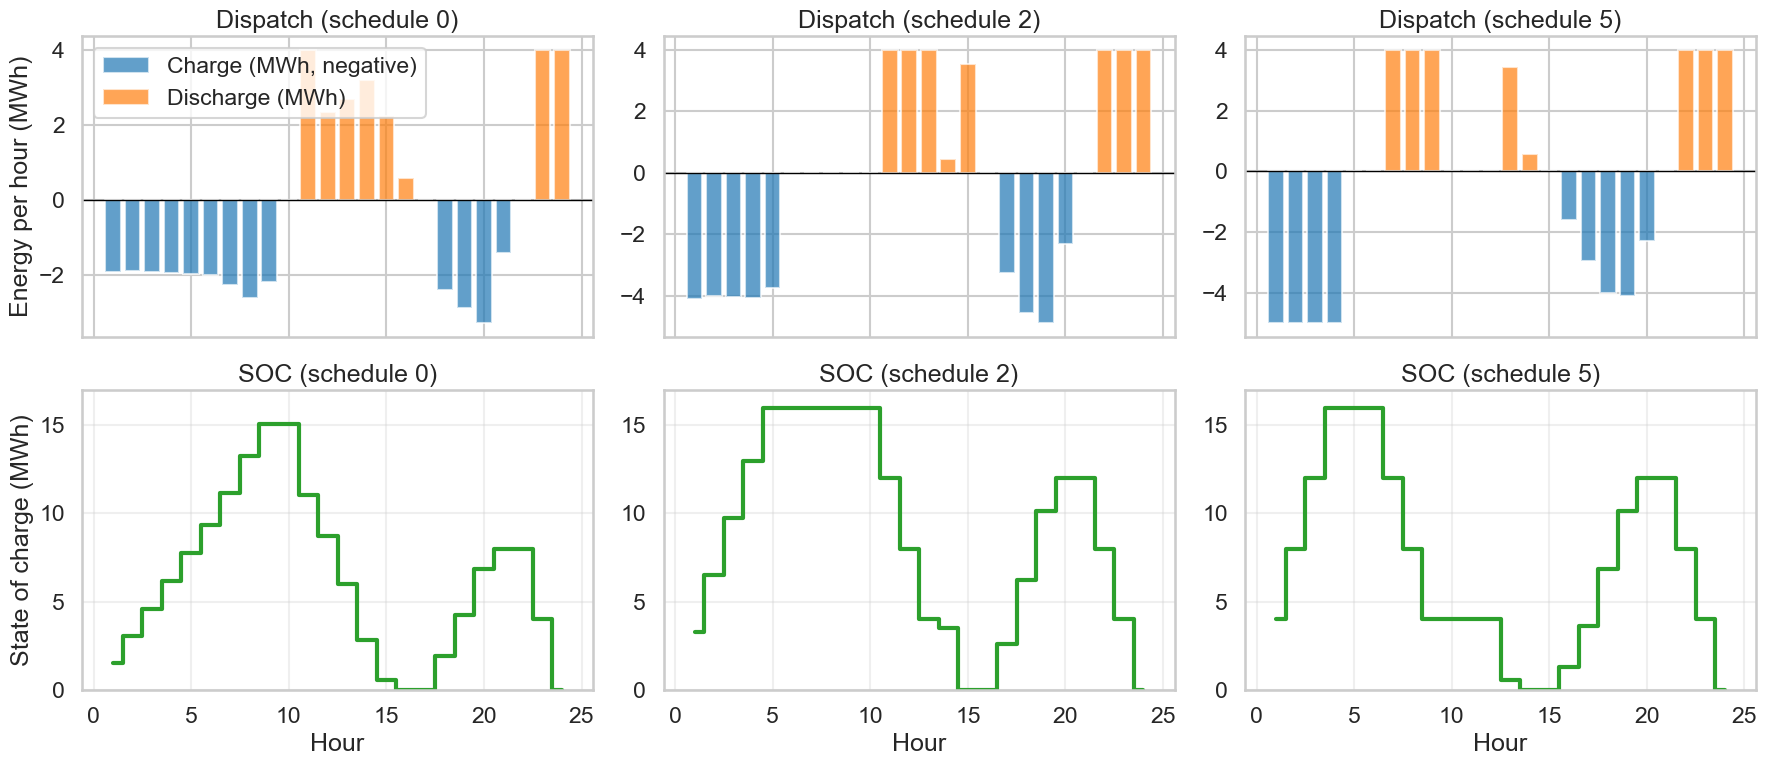

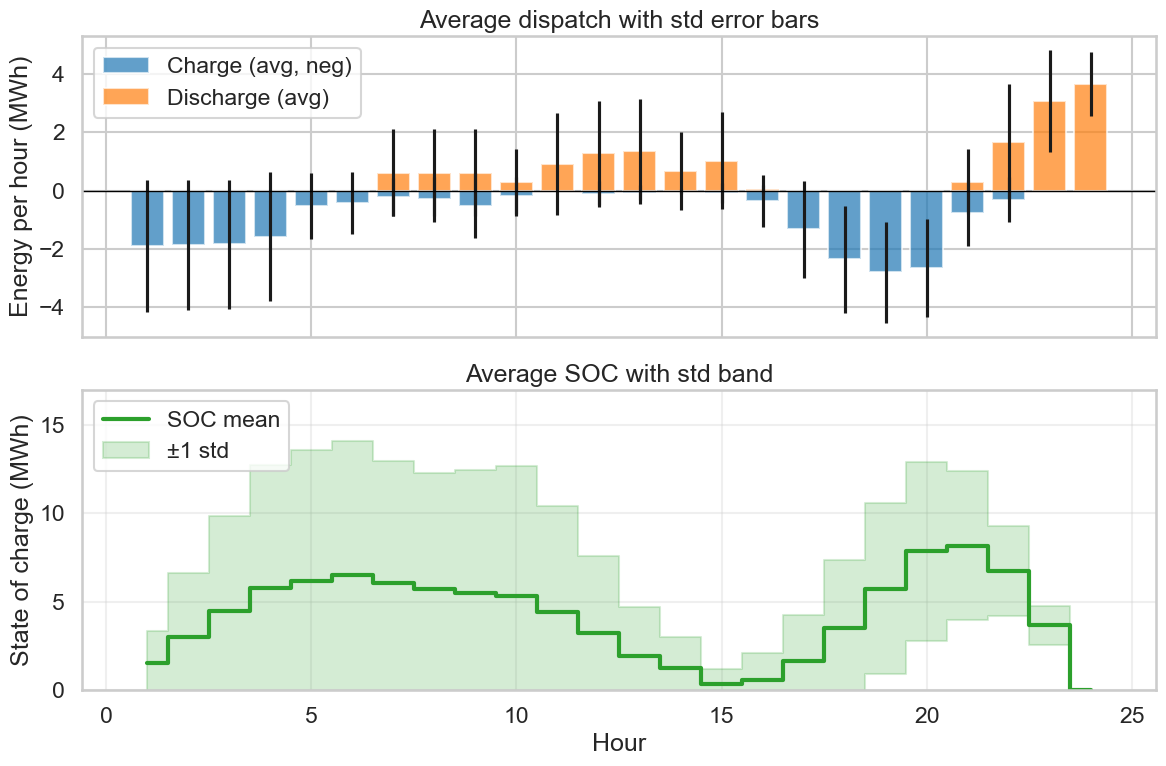

(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'Average dispatch with std error bars'}, ylabel='Energy per hour (MWh)'>,
  <Axes: title={'center': 'Average SOC with std band'}, xlabel='Hour', ylabel='State of charge (MWh)'>))

In [6]:
# Optional warm‑start charging pattern (1=charge, 0=discharge)
charge_pattern = [0]*8 + [1]*4 + [0]*12

# Initialise the solver with battery parameters and the pattern
solver = ClassicalMILPSolverWithWeatherData(df, Pch=5.0, Pdis=4.0, Emax=16.0,
                                            eta_ch=0.8, eta_dis=1.0, max_cycles=2,
                                            charge_pattern=charge_pattern)

# Solve all scenarios (gamma_track=1 for tracking, lambda_switch controls start penalty)
schedules, summary = solver.solve(gamma_track=1.0, lambda_switch=0.0)

print("Summary:", summary)

# Plot an individual schedule
solver.plot_battery_schedule(schedules[0].schedule)

# Compare selected scenarios (e.g. scenarios 0,2,5)
solver.plot_dispatch_comparison(schedules, indices=[0, 2, 5])

# Aggregate across all scenarios
solver.plot_aggregate_schedule(schedules)
